In [1]:
# !kaggle competitions download -f train.csv jigsaw-unintended-bias-in-toxicity-classification -p ./data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Explore data 

In [3]:
PATH = './data/train.csv'
data = pd.read_csv(PATH)

In [4]:
print(data.columns)
data.comment_text.head()

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')


0    This is so cool. It's like, 'would you want yo...
1    Thank you!! This would make my life a lot less...
2    This is such an urgent design problem; kudos t...
3    Is this something I'll be able to install on m...
4                 haha you guys are a bunch of losers.
Name: comment_text, dtype: object

Label in the target column, if > 0.5 then the comment is toxic.

## 2. Process data

### 2.1 Subset: female

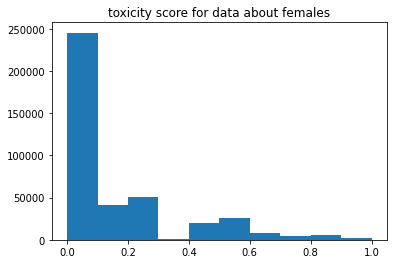

In [5]:
# only look at rows with information for female
data_female = data[~np.isnan(data.female)]

plt.hist(data_female.target)
plt.title('toxicity score for data about females')
plt.show()

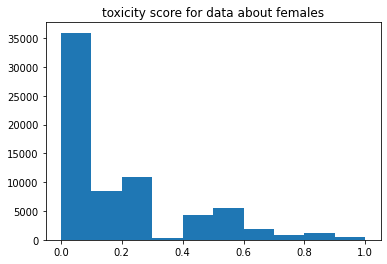

In [6]:
# create balanced dataset: keep comments talking about female 
data_female = data_female[data_female.female > .1]
plt.hist(data_female.target)
plt.title('toxicity score for data about females')
plt.show()

### 2.2 Create a balanced dataset: choose threshold

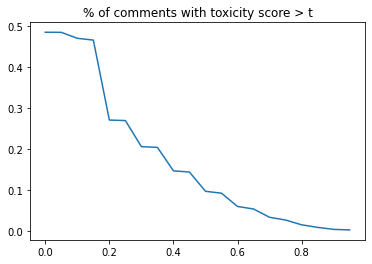

In [32]:
# Need a balanced dataset: see at what threshold we have 50% of data classified as toxic
thresholds = np.arange(0, 1, 0.05)
toxic_rates = [np.mean(data_female.target > t) for t in thresholds]
plt.plot(thresholds, toxic_rates)
plt.title('% of comments with toxicity score > t')
plt.show()

In [8]:
# get labels and threshold = .15
threshold = .15
toxic_rate = np.mean(data_female.target > threshold)
print('% of comments with toxicity scores > {:.2f}: {:.1f}%'.format(
    threshold,
    toxic_rate * 100
))

labels = data_female.target.values > threshold
features = data_female.comment_text.values

% of comments with toxicity scores > 0.15: 46.5%


### 2.3 Preprocessing: stopwords, stem

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
def applymap(func):
        def wrapper(text, *args, **kwargs):
            return list(map(lambda x: func(x, *args, **kwargs), text))

        return wrapper

@applymap
def remove_punctuation(text):
    return re.sub(r"[^\w\s]", "", text)

@applymap
def lower(text):
    return text.lower()

@applymap
def tokenize(text, tokenizer):
    return tokenizer.tokenize(text)

@applymap
def remove_stop_words(text, stopwords):
    return [w for w in text if w not in stopwords]

@applymap
def stem(text, stemmer):
    res = " ".join(list(map(stemmer.stem, text)))
    return res

X_temp = remove_punctuation(features)
X_temp = lower(X_temp)

# tokenize to remove stopwords and stem
tokenizer = RegexpTokenizer(r"\w+")
X_temp = tokenize(X_temp, tokenizer)

X_temp = remove_stop_words(X_temp, set(stopwords.words("english")))
print("hello world")
X_temp = stem(X_temp, PorterStemmer())

hello world


In [57]:
VOCAB_SIZE = 5000

vectorizer = TfidfVectorizer(
    lowercase=False,  # already done
    stop_words=None,  # already done
    max_features=VOCAB_SIZE,  # max vocab size
)

X = vectorizer.fit_transform(X_temp)
# print(vectorizer.get_feature_names())

In [58]:
# sparse to dense
X = X.toarray()

## 3. Model

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA, TruncatedSVD

SEED = 10

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    labels, 
    test_size=.2,
    random_state=SEED
)

In [60]:
clf = LogisticRegression(random_state=SEED, max_iter=500)
clf = clf.fit(X_train, y_train)

In [61]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy: {:.2f}'.format(clf.score(X_test, y_test)))

              precision    recall  f1-score   support

       False       0.71      0.80      0.75      7468
        True       0.73      0.62      0.67      6441

    accuracy                           0.72     13909
   macro avg       0.72      0.71      0.71     13909
weighted avg       0.72      0.72      0.72     13909

accuracy: 0.72


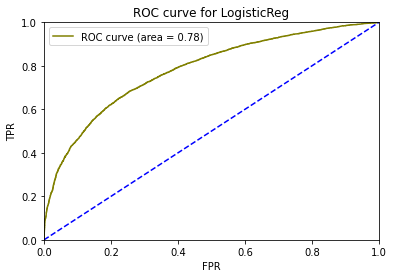

In [63]:
y_proba = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, c='olive', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='b', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LogisticReg')
plt.legend()
plt.show()

### 3.2 Dimensionality reduction

In [50]:
N_COMPONENTS = 1000
pca = PCA(random_state=SEED, n_components=N_COMPONENTS)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=10,
    svd_solver='auto', tol=0.0, whiten=False)

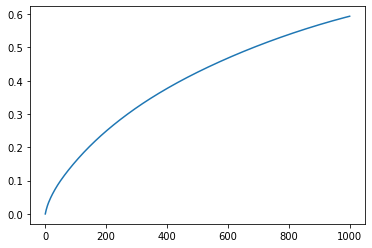

In [51]:
expl_variance = [0]
for i in range(N_COMPONENTS):
    expl_variance.append(expl_variance[i] + pca.explained_variance_ratio_[i])
plt.plot(range(N_COMPONENTS+1), expl_variance)